# CIFAR100 transfer
Exploring applicability of models trained on CIFAKE for 'real' images

In [1]:
import torch

import numpy as np

from classes import CI_LOADER, CIFAKE_CNN
from test import test_model, test_thresh_size, visualise


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Running...
Running...


In [194]:
def find_extrema(df):
    return df.loc[[df.idxmax()[0]]], df.loc[[df.idxmin()[0]]]

### Data loading

In [2]:
# The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes,
# with 600 images per class. The 100 classes in the CIFAR-100 are grouped
# into 20 superclasses. Each image comes with a "fine" label (the class to
# which it belongs) and a "coarse" label (the superclass to which it belongs).
# There are 50000 training images and 10000 test images.
# The meta file contains the label names of each class and superclass.

# #https://www.kaggle.com/datasets/fedesoriano/cifar100?resource=download

In [3]:
# classes = "beaver", "dolphin", "otter", "seal", "whale",
# "aquarium", "fish", "flatfish", "ray", "shark", "trout"
# 11-15) orchids, poppies, roses, sunflowers, tulips
# 16-20) bottles, bowls, cans, cups, plates
# 21-25) apples, mushrooms, oranges, pears, sweet peppers
# 26-30) clock, computer keyboard, lamp, telephone, television
# 31-35) bed, chair, couch, table, wardrobe
# 36-40) bee, beetle, butterfly, caterpillar, cockroach
# 41-45) bear, leopard, lion, tiger, wolf
# 46-50) bridge, castle, house, road, skyscraper
# 51-55) cloud, forest, mountain, plain, sea
# 56-60) camel, cattle, chimpanzee, elephant, kangaroo
# 61-65) fox, porcupine, possum, raccoon, skunk
# 66-70) crab, lobster, snail, spider, worm
# 71-75) baby, boy, girl, man, woman
# 76-80) crocodile, dinosaur, lizard, snake, turtle
# 81-85) hamster, mouse, rabbit, shrew, squirrel
# 86-90) maple, oak, palm, pine, willow
# 91-95) bicycle, bus, motorcycle, pickup truck, train
# 96-100) lawn-mower, rocket, streetcar, tank, tractor

In [98]:
def unpickle_cifar100(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '../data/CIFAR100/meta' # change this path`\
metadata = unpickle_cifar100(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))
class_dict = dict(list(enumerate(metadata[b'fine_label_names'])))


In [142]:
# loading from kaggel datacard https://www.kaggle.com/datasets/fedesoriano/cifar100/data
data_pre_path = '../data/CIFAR100/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle_cifar100(data_train_path)
data_test_dict = unpickle_cifar100(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(np.array([data_train_dict[b'coarse_labels'], data_train_dict[b'fine_labels']]))


data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])
label_test_fine = np.array(data_test_dict[b'fine_labels'])


In [138]:
# import matplotlib.pyplot as plt
# plt.imshow((data_train[0]/255).reshape(3,32,32).transpose(1,2,0))

In [139]:
superclass_dict

{0: b'aquatic_mammals',
 1: b'fish',
 2: b'flowers',
 3: b'food_containers',
 4: b'fruit_and_vegetables',
 5: b'household_electrical_devices',
 6: b'household_furniture',
 7: b'insects',
 8: b'large_carnivores',
 9: b'large_man-made_outdoor_things',
 10: b'large_natural_outdoor_scenes',
 11: b'large_omnivores_and_herbivores',
 12: b'medium_mammals',
 13: b'non-insect_invertebrates',
 14: b'people',
 15: b'reptiles',
 16: b'small_mammals',
 17: b'trees',
 18: b'vehicles_1',
 19: b'vehicles_2'}

In [140]:
## cf cifar10
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [143]:
# from classes import CIFAKE_loader
testdata = CI_LOADER(list(zip(data_test, label_test)), source='CIFAR100')
testdata_fine = CI_LOADER(list(zip(data_test, label_test_fine)), source='CIFAR100')

### Testing base model

In [187]:
# load model, test on test set
model = CIFAKE_CNN()
model.load_state_dict(torch.load("../models/base_model.pth"))

<All keys matched successfully>

In [170]:
from sklearn.metrics import accuracy_score, recall_score
import pandas as pd

def score_content_preds(gold: list, preds: list, thresh: float = 0.5,
                        class_dict=superclass_dict) -> tuple[float]:
    """Make binary label decision for y_pred based on threshold, 
    calculate and return evaluation metrics with y_true."""

    y_pred = [1 if pred >= thresh else 0 for pred in preds]

    real_fake_preds = y_pred
    y_pred = list()
    gold = [x[1] for x in gold]
    for pred, g in zip(real_fake_preds, gold):
        if pred == 1: #correctly id'd as real img in cifar100
            y_pred.append(g)
        else:
            y_pred.append(-1)
    labs = list(set([int(x) for x in gold]))

    cols = [class_dict[x] if x!=-1 else 'FAKE' 
            for x in labs]+['Average']

    acc = accuracy_score(gold, y_pred)
    rec = recall_score(gold, y_pred, labels=labs, average=None, zero_division=0.0)

    # Add per-class measures & averages
    eval = pd.DataFrame([np.append(m, sum(m)/(len(m))) for m in [rec]],
                        index=["recall"],
                        columns=cols).transpose()

    print(f'\nPerformance (n={len(gold)} test imgs, decision threshold={thresh})')
    print(f'Overall accuracy: {acc:.2%}\n', eval, sep='\n')

    return acc, eval



In [171]:
gold, preds = test_model(model, testdata)
acc, eval = score_content_preds(gold, preds)

  0%|          | 0/312 [00:00<?, ?it/s]


Performance (n=9984 test imgs, decision threshold=0.5)
Overall accuracy: 95.45%

                                     recall
b'aquatic_mammals'                 0.956000
b'fish'                            0.977956
b'flowers'                         0.937751
b'food_containers'                 0.954000
b'fruit_and_vegetables'            0.965863
b'household_electrical_devices'    0.924000
b'household_furniture'             0.971944
b'insects'                         0.905812
b'large_carnivores'                0.961924
b'large_man-made_outdoor_things'   0.967936
b'large_natural_outdoor_scenes'    0.929719
b'large_omnivores_and_herbivores'  0.963928
b'medium_mammals'                  0.972000
b'non-insect_invertebrates'        0.947791
b'people'                          0.944000
b'reptiles'                        0.962000
b'small_mammals'                   0.977956
b'trees'                           0.978000
b'vehicles_1'                      0.943888
b'vehicles_2'                      0.9

In [172]:
eval.describe()

,recall
count,21.000000
mean,0.954523
std,0.019080
min,0.905812
25%,0.944000
50%,0.956000
75%,0.967936
max,0.978000


In [195]:
find_extrema(eval)

(          recall
 b'trees'   0.978,
               recall
 b'insects'  0.905812)

In [174]:
gold, preds = test_model(model, testdata_fine)
acc_fine, eval_fine = score_content_preds(gold, preds, class_dict=class_dict)

  0%|          | 0/312 [00:00<?, ?it/s]


Performance (n=9984 test imgs, decision threshold=0.5)
Overall accuracy: 95.45%

                    recall
b'apple'          0.970000
b'aquarium_fish'  0.980000
b'baby'           0.950000
b'bear'           0.990000
b'beaver'         0.960000
...                    ...
b'willow_tree'    1.000000
b'wolf'           0.990000
b'woman'          0.930000
b'worm'           0.909091
Average           0.954505

[101 rows x 1 columns]


In [175]:
eval_fine.describe()

,recall
count,101.000000
mean,0.954505
std,0.039526
min,0.787879
25%,0.940000
50%,0.960000
75%,0.980000
max,1.000000


In [196]:
find_extrema(eval_fine)

(           recall
 b'castle'     1.0,
           recall
 b'sea'  0.787879)

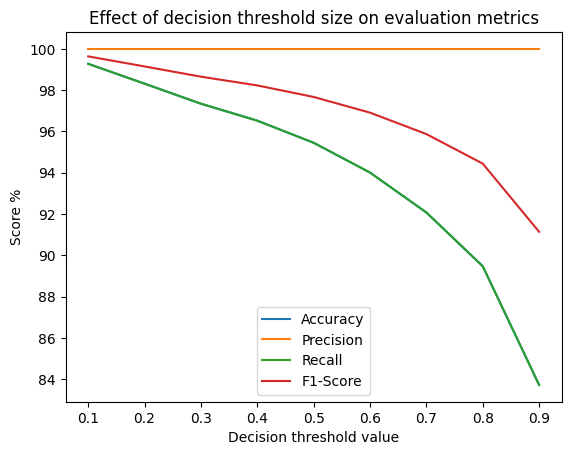

In [193]:
thresh_df_ci100 = test_thresh_size([1.0 for x in gold], preds)
visualise(thresh_df_ci100)


In [15]:
thresh_df_ci100

,Accuracy,Precision,Recall,F1-Score
0.1,99.278846,100.0,99.278846,99.638118
0.2,98.317308,100.0,98.317308,99.151515
0.3,97.345753,100.0,97.345753,98.655027
0.4,96.524439,100.0,96.524439,98.231487
0.5,95.452724,100.0,95.452724,97.673465
0.6,94.010417,100.0,94.010417,96.912752
0.7,92.077324,100.0,92.077324,95.875267
0.8,89.473157,100.0,89.473157,94.444151
0.9,83.723958,100.0,83.723958,91.141035


In [16]:
thresh_df_ci100.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.000000,9.0,9.000000,9.000000
mean,94.022658,100.0,94.022658,96.858091
std,4.949295,0.0,4.949295,2.698359
min,83.723958,100.0,83.723958,91.141035
25%,92.077324,100.0,92.077324,95.875267
50%,95.452724,100.0,95.452724,97.673465
75%,97.345753,100.0,97.345753,98.655027
max,99.278846,100.0,99.278846,99.638118


### Comparison

### Mini

In [188]:
mini = CIFAKE_CNN()
mini.load_state_dict(torch.load("../models/mini_model.pth"))

gold_mini, preds_mini = test_model(mini, testdata)
acc_mini, eval_mini = score_content_preds(gold_mini, preds_mini)

  0%|          | 0/312 [00:00<?, ?it/s]


Performance (n=9984 test imgs, decision threshold=0.5)
Overall accuracy: 86.49%

                                     recall
b'aquatic_mammals'                 0.876000
b'fish'                            0.861723
b'flowers'                         0.684739
b'food_containers'                 0.920000
b'fruit_and_vegetables'            0.791165
b'household_electrical_devices'    0.838000
b'household_furniture'             0.899800
b'insects'                         0.781563
b'large_carnivores'                0.887776
b'large_man-made_outdoor_things'   0.899800
b'large_natural_outdoor_scenes'    0.917671
b'large_omnivores_and_herbivores'  0.931864
b'medium_mammals'                  0.858000
b'non-insect_invertebrates'        0.879518
b'people'                          0.890000
b'reptiles'                        0.878000
b'small_mammals'                   0.971944
b'trees'                           0.922000
b'vehicles_1'                      0.763527
b'vehicles_2'                      0.8

In [190]:
eval_mini.describe()

,recall
count,21.000000
mean,0.864854
std,0.065367
min,0.684739
25%,0.844000
50%,0.878000
75%,0.899800
max,0.971944


In [198]:
find_extrema(eval_mini)

(                    recall
 b'small_mammals'  0.971944,
               recall
 b'flowers'  0.684739)

In [200]:
gold_mini_fine, preds_mini_fine = test_model(mini, testdata_fine)
acc_mini_fine, eval_mini_fine = score_content_preds(
    gold_mini_fine, preds_mini_fine, class_dict=class_dict)

  0%|          | 0/312 [00:00<?, ?it/s]


Performance (n=9984 test imgs, decision threshold=0.5)
Overall accuracy: 86.49%

                    recall
b'apple'          0.910000
b'aquarium_fish'  0.780000
b'baby'           0.940000
b'bear'           0.920000
b'beaver'         0.970000
...                    ...
b'willow_tree'    0.970000
b'wolf'           0.910000
b'woman'          0.910000
b'worm'           0.808081
Average           0.864819

[101 rows x 1 columns]


In [201]:
eval_mini_fine.describe()

,recall
count,101.000000
mean,0.864819
std,0.107547
min,0.484848
25%,0.820000
50%,0.890000
75%,0.949495
max,1.000000


In [202]:
find_extrema(eval_mini_fine)

(              recall
 b'porcupine'     1.0,
                 recall
 b'sunflower'  0.484848)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

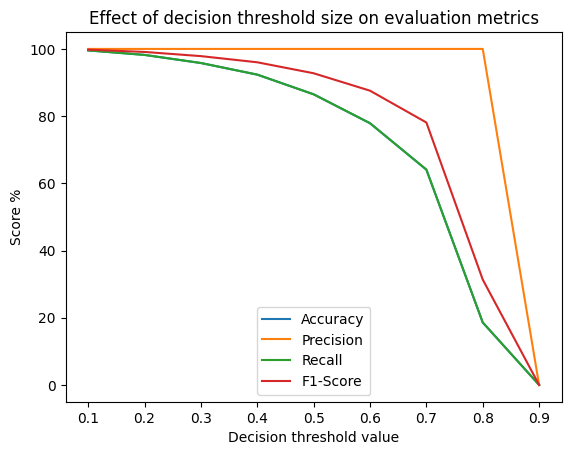

In [205]:
thresh_df_ci100_mini = test_thresh_size([1.0 for x in gold_mini], preds_mini)
visualise(thresh_df_ci100_mini)


### Attention model

In [210]:
attn = CIFAKE_CNN(attn=True)
attn.load_state_dict(torch.load("../models/SRM_model.pth"))

gold_attn, preds_attn = test_model(attn, testdata)
acc_attn, eval_attn = score_content_preds(gold_attn, preds_attn)

  0%|          | 0/312 [00:00<?, ?it/s]


Performance (n=9984 test imgs, decision threshold=0.5)
Overall accuracy: 81.67%

                                     recall
b'aquatic_mammals'                 0.894000
b'fish'                            0.915832
b'flowers'                         0.704819
b'food_containers'                 0.782000
b'fruit_and_vegetables'            0.811245
b'household_electrical_devices'    0.742000
b'household_furniture'             0.849699
b'insects'                         0.701403
b'large_carnivores'                0.831663
b'large_man-made_outdoor_things'   0.865731
b'large_natural_outdoor_scenes'    0.875502
b'large_omnivores_and_herbivores'  0.845691
b'medium_mammals'                  0.840000
b'non-insect_invertebrates'        0.833333
b'people'                          0.736000
b'reptiles'                        0.806000
b'small_mammals'                   0.905812
b'trees'                           0.872000
b'vehicles_1'                      0.709419
b'vehicles_2'                      0.8

In [211]:
eval_attn.describe()

,recall
count,21.000000
mean,0.816708
std,0.065734
min,0.701403
25%,0.782000
50%,0.831663
75%,0.865731
max,0.915832


In [212]:
find_extrema(eval_attn)

(           recall
 b'fish'  0.915832,
               recall
 b'insects'  0.701403)

In [213]:
gold_attn_fine, preds_attn_fine = test_model(attn, testdata_fine)
acc_attn_fine, eval_attn_fine = score_content_preds(
    gold_attn_fine, preds_attn_fine, class_dict=class_dict)

  0%|          | 0/312 [00:00<?, ?it/s]


Performance (n=9984 test imgs, decision threshold=0.5)
Overall accuracy: 81.67%

                    recall
b'apple'          0.890000
b'aquarium_fish'  0.900000
b'baby'           0.770000
b'bear'           0.910000
b'beaver'         0.900000
...                    ...
b'willow_tree'    0.970000
b'wolf'           0.910000
b'woman'          0.680000
b'worm'           0.858586
Average           0.816678

[101 rows x 1 columns]


In [214]:
eval_attn_fine.describe()

,recall
count,101.000000
mean,0.816678
std,0.095678
min,0.555556
25%,0.760000
50%,0.830000
75%,0.898990
max,0.970000


In [215]:
find_extrema(eval_attn_fine)

(        recall
 b'ray'    0.97,
                 recall
 b'butterfly'  0.555556)

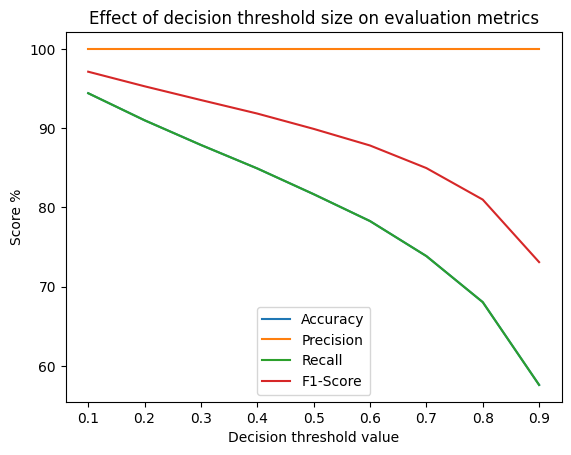

In [216]:
thresh_df_ci100_attn = test_thresh_size([1.0 for x in gold_attn], preds_attn)
visualise(thresh_df_ci100_attn)